@author: Reinelle Bugnot <br>
@contact: reinbugnot@gmail.com

## Brazil Real Estate Listings Exploratory Data Analysis

This Notebook is a comprehensive analysis of the Brazil Real Estate Listings dataset by Properati. The dataset includes rent and sales data for properties in Brazil since 2015. Properati is a competitive marketplace for Latin American real estate that strives to assist consumers in purchasing and renting homes, while simultaneously providing location-specific property databases for the public. <br>

**Research Question:**

Being that we're analyzing the dataset from a listing platform, my goal here is to explore the data and understand **what factors determine the sale price of a Real Estate Unit (REU) in Brazil?**. Answering this question should give us a good understanding of the dynamic of Brazil's Real Estate market which will benefit, for example, real estate agents in pricing the units they are selling, or home-buyers to see whether a unit they're buying is reasonably priced or not. <br>

**Theory:**

Based from my understanding and limited personal experiences in Real Estate, my theory is that **Sale prices are determined by both internal (characteristics of the unit) and external (characteristics of the environment the unit is sold/rented) factors**. Internal factors should play a big part in pricing since of course, bigger and more well-furnished units should generally be more expensive than lesser ones. However, I do think that external factors such as the location of the unit is also important since REU pricing do vary a lot based on location, time, etc. <br>

**Hypothesis:**

Hence, I hypothesize that:
 1. SIZE: Bigger REUs are more expensive than smaller REUs
 2. LOCATION: REUs in Brazil's wealthier districts are more expensive than the REUs in less developed districts
 3. TIME: Seasonality affects sale/rent prices; i.e., REUs are more expensive on some months in a year than others.
 4. TIME: There are years when REUs are more expensive than other years.


### Import Relevant Libraries

In [1]:
## IMPORT LIBRARIES

#Data Management
import os
import gcsfs # file system for google cloud storage
import tqdm.notebook as tq # progress bar library

#Data Handling
import pandas as pd
pd.set_option('display.max_columns', None)

#Data Profiling and EDA
import missingno as msno # nullity analysis
import scipy.stats as st # standard statistic library
import matplotlib.pyplot as plt # basic plots
plt.rcParams.update({'font.size': 14})
import seaborn as sns
from datetime import datetime #for date data

### Moving Data from Cloud to Python

In [2]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'ServiceKey_GoogleCloud.json'

In [58]:
# Import data from BigQuery to Google Cloud Storage (RUN ONCE)

from google.cloud import bigquery
client = bigquery.Client()
bucket_name = 'tm-application'
project = "properati-data-public"
dataset_id = "properties_br"
tables = client.list_tables('properati-data-public.properties_br')

for table in tables:
    destination_uri = "gs://{}/{}".format(bucket_name, table.table_id)
    dataset_ref = bigquery.DatasetReference(project, dataset_id)
    table_ref = dataset_ref.table(table.table_id)

    extract_job = client.extract_table(
        table_ref,
        destination_uri,
        location="US",
    )
    extract_job.result()

    print(
        "Exported {}:{}.{} to {}".format(project, dataset_id, table.table_id, destination_uri)
    )

Exported properati-data-public:properties_br.properties_rent_201501 to gs://tm-application/properties_rent_201501
Exported properati-data-public:properties_br.properties_rent_201502 to gs://tm-application/properties_rent_201502
Exported properati-data-public:properties_br.properties_rent_201503 to gs://tm-application/properties_rent_201503
Exported properati-data-public:properties_br.properties_rent_201504 to gs://tm-application/properties_rent_201504
Exported properati-data-public:properties_br.properties_rent_201505 to gs://tm-application/properties_rent_201505
Exported properati-data-public:properties_br.properties_rent_201506 to gs://tm-application/properties_rent_201506
Exported properati-data-public:properties_br.properties_rent_201507 to gs://tm-application/properties_rent_201507
Exported properati-data-public:properties_br.properties_rent_201508 to gs://tm-application/properties_rent_201508
Exported properati-data-public:properties_br.properties_rent_201509 to gs://tm-applicati

Exported properati-data-public:properties_br.properties_sell_201711 to gs://tm-application/properties_sell_201711
Exported properati-data-public:properties_br.properties_sell_201712 to gs://tm-application/properties_sell_201712
Exported properati-data-public:properties_br.properties_sell_201801 to gs://tm-application/properties_sell_201801
Exported properati-data-public:properties_br.properties_sell_201802 to gs://tm-application/properties_sell_201802


### Initial Data Observations

In [3]:
## Google Cloud Storage to Python (Pandas Dataframe)

filename = 'properties_rent_201501'

fs = gcsfs.GCSFileSystem(project='tm-application-323908')
with fs.open('tm-application/' + filename) as f:
    data = pd.read_csv(f)

Each of the 76 datasets in the properati-public-data is named the following format: **properties_<rent / sell>_<year + month>** <br>

Rent / sell simply tells us the type of listing: whether the unit is for rent or for sale. However, I'm not 100% certain what the date (year + month) represents. It could be:
 1. Date when the property was listed on the platform
 2. Date when the property was sold / occupied
 
According to the GCP overview, "This dataset includes **rent and sales data** for properties in Brazil since 2016" so I'm assuming the date represents the date of actual transaction. Although, the dataset contains data from 2015 to 2018 despite the description claiming it's only data for properties since 2016.

In [4]:
# Sample Data
data.head(3)

,id,created_on,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat_lon,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
0,f73c373e0588bf568164a057dd94203ac87d47b1,2014-08-07,rent,store,Catu,|Brasil|Bahia|Catu|,Brasil,Bahia,NaN,NaN,NaN,NaN,0.0,NaN,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.br/mfye_alugar_outros...,"Otimo Imovel com o melhor valor da regiao, con...",Exclusividade! - Loja Em Catu,https://thumbs4.properati.com/3/jA8isZw8Xju7z3...
1,d6d377927ab49671acdd38aa6f661a460601a88b,2015-01-20,rent,apartment,Pernambuco,|Brasil|Pernambuco|,Brasil,Pernambuco,NaN,"-8.126271,-34.903793",-8.126271,-34.903793,1200.0,BRL,1184.32,383.55,NaN,63.0,6.088095,19.047619,1.0,2.0,NaN,http://www.properati.com.br/w71k_alugar_aparta...,CONTATOS: Claro: 81./ Tim: 81./ Oi: 81./ Vivo:...,"Apartamento de 2 quartos, DCE, 1.º Andar, 63 m...",https://thumbs4.properati.com/0/B9BCwP1HK7NvZI...
2,c6826a9508436920fd59b46a202354f3e4823d22,2014-10-29,rent,store,São Paulo,|Brasil|São Paulo|,Brasil,São Paulo,NaN,"-23.1546253,-45.7906242",-23.154625,-45.790624,0.0,BRL,0.00,0.00,NaN,3800.0,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.br/s41f_alugar_comerc...,CondomÃ­nio com 22 MÃ³dulos de GalpÃµes; 3.80...,"Comercial em Caçapava, no bairro Caçapava",https://thumbs4.properati.com/1/J2n8nXVlvduy6E...


In [5]:
# List all the columns
pd.Series(data.columns)

0                             id
1                     created_on
2                      operation
3                  property_type
4                     place_name
5        place_with_parent_names
6                   country_name
7                     state_name
8                    geonames_id
9                        lat_lon
10                           lat
11                           lon
12                         price
13                      currency
14    price_aprox_local_currency
15               price_aprox_usd
16           surface_total_in_m2
17         surface_covered_in_m2
18              price_usd_per_m2
19                  price_per_m2
20                         floor
21                         rooms
22                      expenses
23                 properati_url
24                   description
25                         title
26               image_thumbnail
dtype: object

The source of the data (GCP) lacks proper labels/descriptions for each column in the dataset, so here's my attempt on interpreting what information each column represents based on the name and sample datapoints:

| Column Name | My Interpretation (and Assumptions) |
|:---|:---|
| id | property id |
| **created_on** | I'm not sure. It could be (a) when the property was built or (b) when the property was listed on the platform. If (a) is true, then the date specified in the filename would probably be the listing date. If (b) is true, then the date in the filename wold probably be the transaction date. |
| operation | is the unit for sale or for rent? |
| property_type | what kind of property is it |
| place_name | location info |
| place_with_parent_names | location info |
| country_name | location info |
| state_name | location info |
| geonames_id | location info |
| lat_lon | location info |
| lat | location info |
| lon | location info |
| **price** | listing/sale price |
| currency | currency of the listing/sale price |
| **price_aprox_local_currency** | since the values is differs from the 'price' column, I'm assuming this is the price which the unit was actually sold (considering potential haggling or repricing). But for the sake of simplicity, I'll assume that Sale price is represented by 'price' |
| price_aprox_usd | sale price in usd |
| **surface_total_in_m2** | total floor area of the unit (considering units with multiple floors)? |
| **surface_covered_in_m2** | total land area covered by the unit?  |
| price_usd_per_m2 | usd price per square meter |
| price_per_m2 | price per square meter |
| **floor** | either (a) number of floors the unit has or (b) which floor in a building/apartment complex the unit is located |
| rooms | number of rooms the unit has |
| expenses | additional expenses? no idea |
| properati_url | url to the property listed |
| description | description of the property which seems to describe the contents of the property. would be good for more qualitative data if used with NLP but the info is written in Brazilian which makes it a bit challenging |
| title | title of the listing |
| image_thumbnail | image thumbnail used |

I will be removing the columns **id, place_with_parent_names, properati_url, description, title, and image_thumbnail** because they don't seem to contain useful data (numerical, categorical, nor ordinal) that could help me in my analysis; and also to save a bit of space in future processing. <br>

Afterwards, I will incorporate the date included in the dataset filename to the list of possible features. Currently, I'll assume that the date represents sale/transaction date.

In [6]:
# Remove id, place_with_parent_names, properati_url, description, title, image_thumbnail
data.drop(['id','place_with_parent_names', 'properati_url', 'description', 'title', 'image_thumbnail'], axis=1, inplace=True)
data.head(3)

,created_on,operation,property_type,place_name,country_name,state_name,geonames_id,lat_lon,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses
0,2014-08-07,rent,store,Catu,Brasil,Bahia,NaN,NaN,NaN,NaN,0.0,NaN,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-20,rent,apartment,Pernambuco,Brasil,Pernambuco,NaN,"-8.126271,-34.903793",-8.126271,-34.903793,1200.0,BRL,1184.32,383.55,NaN,63.0,6.088095,19.047619,1.0,2.0,NaN
2,2014-10-29,rent,store,São Paulo,Brasil,São Paulo,NaN,"-23.1546253,-45.7906242",-23.154625,-45.790624,0.0,BRL,0.00,0.00,NaN,3800.0,NaN,NaN,NaN,NaN,NaN


In [7]:
## Initial Feature Generation

# Create a new column 'list_date' based on the filename
data['transaction_year'] = filename[-6:-2]
data['transaction_month'] = filename[-2:]
data.head(3)

,created_on,operation,property_type,place_name,country_name,state_name,geonames_id,lat_lon,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,transaction_year,transaction_month
0,2014-08-07,rent,store,Catu,Brasil,Bahia,NaN,NaN,NaN,NaN,0.0,NaN,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015,01
1,2015-01-20,rent,apartment,Pernambuco,Brasil,Pernambuco,NaN,"-8.126271,-34.903793",-8.126271,-34.903793,1200.0,BRL,1184.32,383.55,NaN,63.0,6.088095,19.047619,1.0,2.0,NaN,2015,01
2,2014-10-29,rent,store,São Paulo,Brasil,São Paulo,NaN,"-23.1546253,-45.7906242",-23.154625,-45.790624,0.0,BRL,0.00,0.00,NaN,3800.0,NaN,NaN,NaN,NaN,NaN,2015,01


In [8]:
# List all the updated columns
columns = data.columns
pd.Series(columns)

0                     created_on
1                      operation
2                  property_type
3                     place_name
4                   country_name
5                     state_name
6                    geonames_id
7                        lat_lon
8                            lat
9                            lon
10                         price
11                      currency
12    price_aprox_local_currency
13               price_aprox_usd
14           surface_total_in_m2
15         surface_covered_in_m2
16              price_usd_per_m2
17                  price_per_m2
18                         floor
19                         rooms
20                      expenses
21              transaction_year
22             transaction_month
dtype: object

In [9]:
# Clear up memory
del data

### Import Dataset

To streamline future processing, I'll write a function that automatically pulls out the data that I need straight from Google Cloud Storage and into a very welcoming Pandas Dataframe.

In [10]:
## Automate the Transfer of data from GCS to Python (Pandas Dataframe)

def genData(year, column = None, file_count = None):

    DATA = []
    
    for _, _, bucket_data in fs.walk('tm-application/'):

        for filename in tq.tqdm(bucket_data[:file_count]):

            if int(filename[-6:-2]) == year:

                with fs.open('tm-application/' + filename) as f:
                    data = pd.read_csv(f)
                    
                    if column:
                        try:
                            data = data.loc[:, column]
                        except:
                            print('Invalid Column!')                    # Drop unwanted columns
                    
                    else:
                        data.drop(['id','place_with_parent_names', 'properati_url', 'description', 'title', 'image_thumbnail'], axis=1, inplace=True)

                        # Add list_date column
                        data['transaction_year'] = filename[-6:-2]
                        data['transaction_month'] = filename[-2:]

                    DATA.append(data.values)
    
    if column:
        DATA = pd.DataFrame(np.concatenate(DATA), columns=[column])
    else:
        DATA = pd.DataFrame(np.concatenate(DATA), columns=columns)
        
    print("Load Complete!")

    return DATA

!! Since the memory of my current (but temporary, until Sept) computer cannot handle loading and processing the whole Brazil Real Estate Listing dataset at once, I will be splitting the Dataset by year and perform year-by-year analysis instead <br>

The following data are loaded and processed on seperate instances.

For the main analysis in the next section I will be focused on using the 2016 Sales Data as it is one of the most populated datasetsw with 4.2 million datapoints. Afterwards, I will perform cross-year analysis to check if the same patterns hold true for other years -- and to check if the year of sale itself is correlated with the target variable 'price'.

In [11]:
###############

set_year = 2016

###############

In [12]:
DATA = genData(set_year)
print("Shape of " + str(set_year) +  " DATA: " + str(DATA.shape))

D:\Users\Rein\Anaconda3\envs\PythonGPU\lib\site-packages\IPython\core\interactiveshell.py:3242: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):



Load Complete!
Shape of 2016 DATA: (4178421, 23)


### Data Profiling and Cleaning

#### Handling Missing Numbers

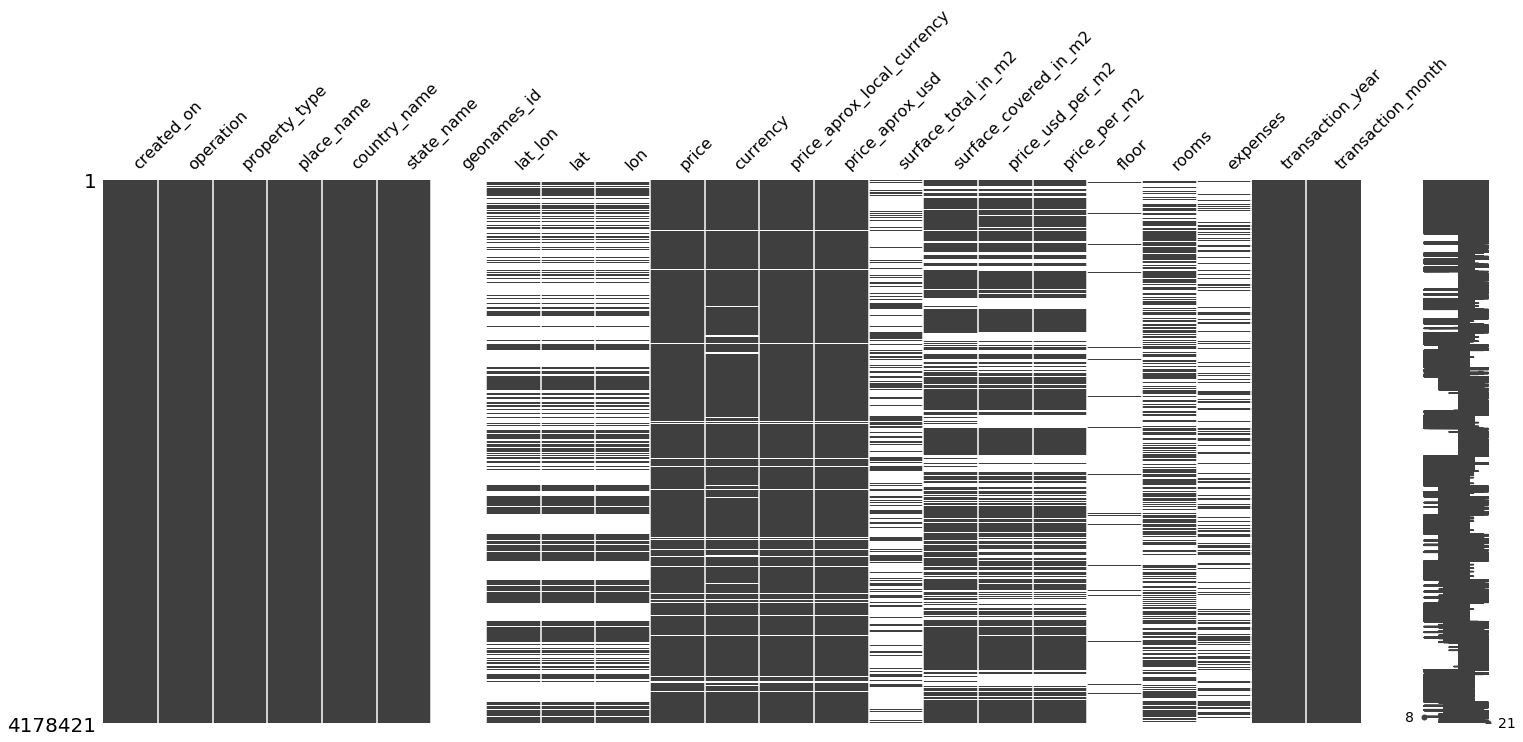

In [13]:
# Visual representation of missing data
msno.matrix(DATA)

the missingno library provides a really nice way of visualizing nullity of a dataset. Each white line represents an empty cell in our data. To specifically quantify the percentages ...

In [14]:
# Missing Data per column in percentages
DATA.isna().mean() * 100

created_on                      0.000000
operation                       0.000000
property_type                   0.000000
place_name                      0.000000
country_name                    0.000000
state_name                      0.000000
geonames_id                   100.000000
lat_lon                        53.455049
lat                            53.455049
lon                            53.455049
price                           3.755869
currency                        6.491926
price_aprox_local_currency      3.755869
price_aprox_usd                 3.755869
surface_total_in_m2            72.674917
surface_covered_in_m2          25.300945
price_usd_per_m2               31.743857
price_per_m2                   31.822380
floor                          96.221467
rooms                          43.292646
expenses                       70.015156
transaction_year                0.000000
transaction_month               0.000000
dtype: float64

This shows that a couple columns that we have are dominated by null values which isn't ideal for Data analysis. For this EDA, I'll only focus on the features with less than 50% nullity.

In [15]:
# Removing all columns that exceeds the given nullity threshold
null_threshold = 50
DATA = DATA[columns[(DATA.isna().mean() * 100) <= null_threshold]]
DATA.isna().mean() * 100

created_on                     0.000000
operation                      0.000000
property_type                  0.000000
place_name                     0.000000
country_name                   0.000000
state_name                     0.000000
price                          3.755869
currency                       6.491926
price_aprox_local_currency     3.755869
price_aprox_usd                3.755869
surface_covered_in_m2         25.300945
price_usd_per_m2              31.743857
price_per_m2                  31.822380
rooms                         43.292646
transaction_year               0.000000
transaction_month              0.000000
dtype: float64

In [16]:
# Remove rows with empty price values
DATA.dropna(subset = ['price'], inplace=True)

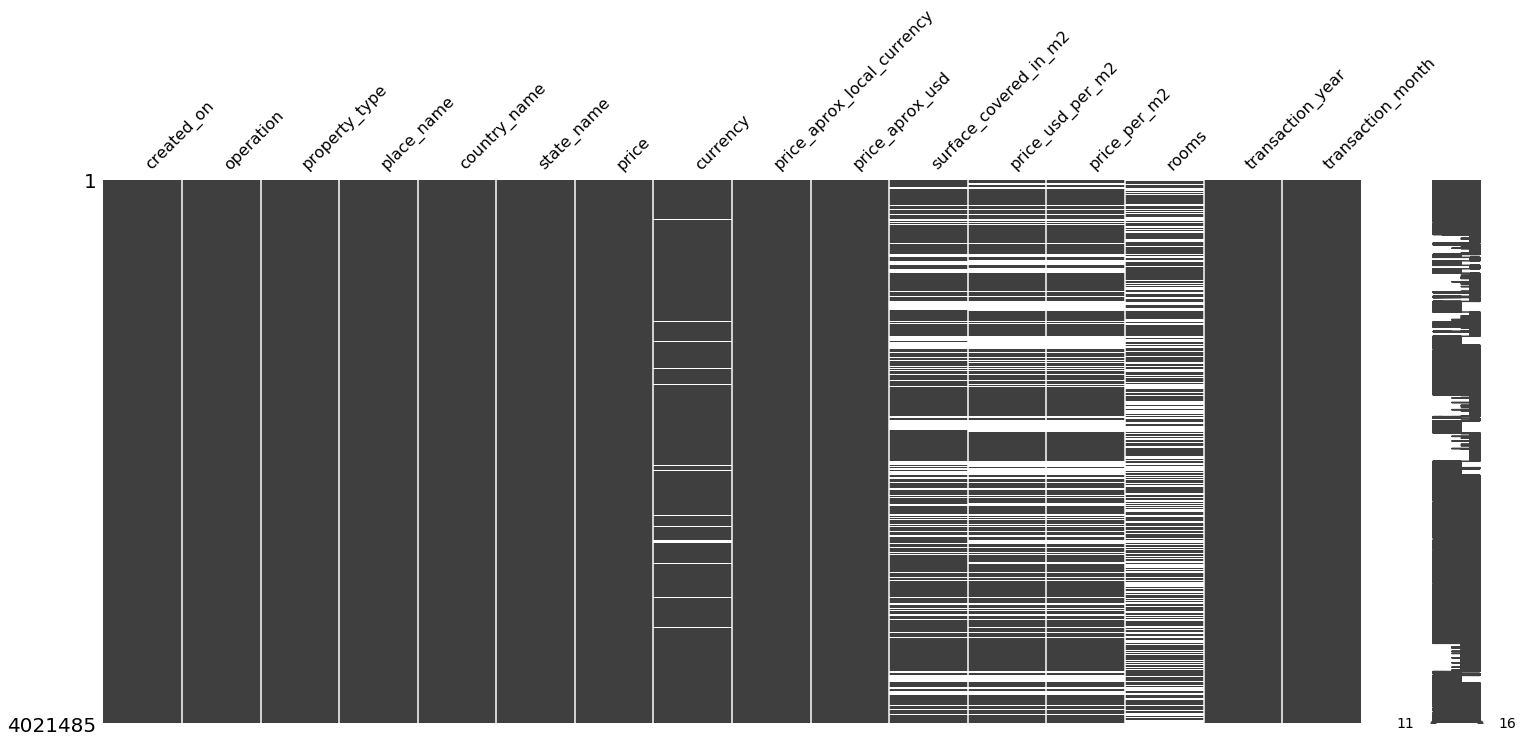

In [17]:
# Visual representation of missing data
msno.matrix(DATA)

#### Numerical and Categorical Data

Next step is to seperate the numerical data from the categorical data; converting both to their proper formats. Afterwards, I will perform label-encoding in order to represent the categorical data we have into a numerical format.

In [18]:
for i in range(DATA.shape[1]):
    try:
        DATA.iloc[:,i] = pd.to_numeric(DATA.iloc[:,i])
    except:
        pass

In [19]:
# Subset of all object data types
DATA.select_dtypes(include='object')

,created_on,operation,property_type,place_name,country_name,state_name,currency
0,2015-07-01,rent,house,Acre,Brasil,Acre,BRL
2,2015-12-01,rent,apartment,Goiás,Brasil,Goiás,BRL
3,2015-12-01,rent,house,Alagoas,Brasil,Alagoas,BRL
4,2015-07-11,rent,house,Alagoas,Brasil,Alagoas,BRL
5,2015-12-01,rent,apartment,Alagoas,Brasil,Alagoas,BRL
...,...,...,...,...,...,...,...
4178416,2016-06-21,sell,house,Aberta dos Morros,Brasil,Rio Grande do Sul,BRL
4178417,2016-06-21,sell,apartment,Guarujá,Brasil,Rio Grande do Sul,BRL
4178418,2016-06-21,sell,house,Aberta dos Morros,Brasil,Rio Grande do Sul,BRL
4178419,2016-10-23,sell,house,Cidreira,Brasil,Rio Grande do Sul,BRL


In [20]:
# Subset of all numeric data types
numeric_features = DATA.select_dtypes(include='number')
numeric_features

,price,price_aprox_local_currency,price_aprox_usd,surface_covered_in_m2,price_usd_per_m2,price_per_m2,rooms,transaction_year,transaction_month
0,4100.0,3836.06,1171.46,NaN,NaN,NaN,2.0,2016,1
2,500.0,407.00,124.29,NaN,NaN,NaN,NaN,2016,1
3,450.0,449.99,137.42,NaN,NaN,NaN,NaN,2016,1
4,2500.0,2499.99,763.45,NaN,NaN,NaN,NaN,2016,1
5,1400.0,1399.98,427.53,NaN,NaN,NaN,NaN,2016,1
...,...,...,...,...,...,...,...,...,...
4178416,680000.0,681581.85,208142.02,270.0,770.896370,2518.518519,NaN,2016,12
4178417,270000.0,270628.07,82644.62,67.0,1233.501791,4029.850746,NaN,2016,12
4178418,190000.0,198650.69,60664.11,42.0,1444.383571,4523.809524,NaN,2016,12
4178419,172000.0,172400.09,52647.68,120.0,438.730667,1433.333333,NaN,2016,12


#### Label Encoding

In [21]:
# Label encode all categorical data

CAT_LABELS = ['operation', 'property_type', 'place_name', 'country_name', 'state_name']
CAT_KEYS = []

for i in CAT_LABELS:
    values, keys = pd.factorize(DATA[i])
    DATA[i] = values
    CAT_KEYS.append(keys)

In [22]:
# Subset of all numeric data types
DATA.select_dtypes(include='number')

,operation,property_type,place_name,country_name,state_name,price,price_aprox_local_currency,price_aprox_usd,surface_covered_in_m2,price_usd_per_m2,price_per_m2,rooms,transaction_year,transaction_month
0,0,0,0,0,0,4100.0,3836.06,1171.46,NaN,NaN,NaN,2.0,2016,1
2,0,1,1,0,1,500.0,407.00,124.29,NaN,NaN,NaN,NaN,2016,1
3,0,0,2,0,2,450.0,449.99,137.42,NaN,NaN,NaN,NaN,2016,1
4,0,0,2,0,2,2500.0,2499.99,763.45,NaN,NaN,NaN,NaN,2016,1
5,0,1,2,0,2,1400.0,1399.98,427.53,NaN,NaN,NaN,NaN,2016,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4178416,1,0,2655,0,20,680000.0,681581.85,208142.02,270.0,770.896370,2518.518519,NaN,2016,12
4178417,1,1,100,0,20,270000.0,270628.07,82644.62,67.0,1233.501791,4029.850746,NaN,2016,12
4178418,1,0,2655,0,20,190000.0,198650.69,60664.11,42.0,1444.383571,4523.809524,NaN,2016,12
4178419,1,0,3195,0,20,172000.0,172400.09,52647.68,120.0,438.730667,1433.333333,NaN,2016,12


In [23]:
# Update numeric_feature subset to include label-encoded data
numeric_features = DATA.select_dtypes(include='number')

#### Handling Outliers

In [24]:
numeric_features.describe(percentiles=[0.05,0.5,0.95])

,operation,property_type,place_name,country_name,state_name,price,price_aprox_local_currency,price_aprox_usd,surface_covered_in_m2,price_usd_per_m2,price_per_m2,rooms,transaction_year,transaction_month
count,4.021485e+06,4.021485e+06,4.021485e+06,4021485.0,4.021485e+06,4.021485e+06,4.021485e+06,4.021485e+06,2.995989e+06,2.852029e+06,2.848748e+06,2.332054e+06,4021485.0,4.021485e+06
mean,8.986026e-01,7.604974e-01,8.966328e+02,0.0,8.979312e+00,7.493559e+05,7.558788e+05,2.308309e+05,5.217824e+03,2.065621e+03,6.742589e+03,2.048236e+00,2016.0,6.550604e+00
std,3.018542e-01,5.571130e-01,8.309128e+02,0.0,5.374988e+00,1.499651e+06,1.507932e+06,4.604935e+05,3.282575e+06,3.161105e+04,1.030217e+05,1.713934e+00,0.0,3.421240e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.973247e-04,1.000000e+00,2016.0,1.000000e+00
5%,0.000000e+00,0.000000e+00,7.500000e+01,0.0,6.000000e+00,8.000000e+02,7.994980e+02,2.441520e+02,4.000000e+01,7.213080e+00,2.400000e+01,1.000000e+00,2016.0,1.000000e+00
50%,1.000000e+00,1.000000e+00,5.790000e+02,0.0,6.000000e+00,4.300000e+05,4.364609e+05,1.332868e+05,9.500000e+01,1.450715e+03,4.737705e+03,2.000000e+00,2016.0,7.000000e+00
95%,1.000000e+00,2.000000e+00,2.627000e+03,0.0,2.000000e+01,2.400000e+06,2.400000e+06,7.329139e+05,3.800000e+02,3.769829e+03,1.228324e+04,4.000000e+00,2016.0,1.200000e+01
max,1.000000e+00,3.000000e+00,5.187000e+03,0.0,2.600000e+01,2.600000e+08,1.619085e+08,4.944376e+07,2.147484e+09,9.216307e+06,3.000000e+07,4.000000e+01,2016.0,1.200000e+01


OBSERVATIONS: <br>
 * 'country_name' and 'transaction_year' contains contant values (as expected) so we can safely drop the column as it contains no relevant information.
 * 'surface_covered_in_m2' seems to have an outlier past the 95th percentile (or just a really big house?)
 * 'rooms' seems to have an outlier past the 95th percentile (with 40 rooms?)
 * same goes with 'price'

In [25]:
# Drop country_name and transaction_year
numeric_features.drop(labels=['country_name', 'transaction_year'], axis=1, inplace=True)

D:\Users\Rein\Anaconda3\envs\PythonGPU\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Just to confirm my theory before dropping suspected outliers, i'll plot the distributions to see if these outliers do have concerning effects on the data

Text(0.5, 1.0, 'Number of Surface Covered in m2 Distribution')

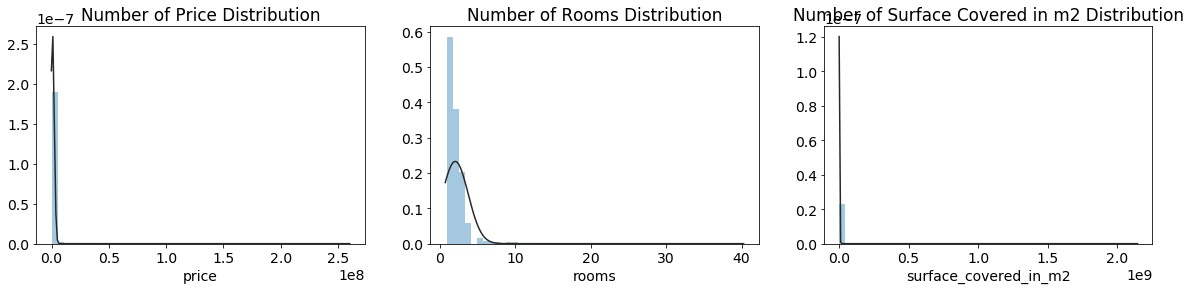

In [26]:
# Distribution of Rooms (with suspected outliers)

fig, ax = plt.subplots(1,3, figsize=(20,4))

y1 = numeric_features.price[~numeric_features.price.isna()]
y2 = numeric_features.rooms[~numeric_features.rooms.isna()]
y3 = numeric_features.surface_covered_in_m2[~numeric_features.surface_covered_in_m2.isna()]

sns.distplot(y1, ax=ax[0], kde=False, fit=st.norm)
ax[0].set_title('Number of Price Distribution')

sns.distplot(y2, ax=ax[1], kde=False, fit=st.norm)
ax[1].set_title('Number of Rooms Distribution')

sns.distplot(y3, ax=ax[2], kde=False, fit=st.norm)
ax[2].set_title('Number of Surface Covered in m2 Distribution')


Looks like the data outside the 95th percentile do have drastic effects on how our data is distributed. Hence, I think it's a good idea to remove those data points to remove the skew in our distribution. <br>

Since the 'rooms' column only operate on a limited range of values, i'll first drop the outliers for price and surface covered and see if I will have to adjust the percentile for number of rooms (since dropping surface covered might simultaneously drop some multi-room units)

In [27]:
# Remove outliers outside the 95th percentile for PRICE
upper_quant = numeric_features.price.quantile([.95])
numeric_features = numeric_features.loc[(numeric_features.price < upper_quant.values[0])]

# Remove outliers outside the 5th to 95th percentile for surface_covered_in_m2
upper_quant = numeric_features.surface_covered_in_m2.quantile([.95])
numeric_features = numeric_features.loc[(numeric_features.surface_covered_in_m2 < upper_quant.values[0])]

Text(0.5, 1.0, 'Number of Surface Covered in m2 Distribution')

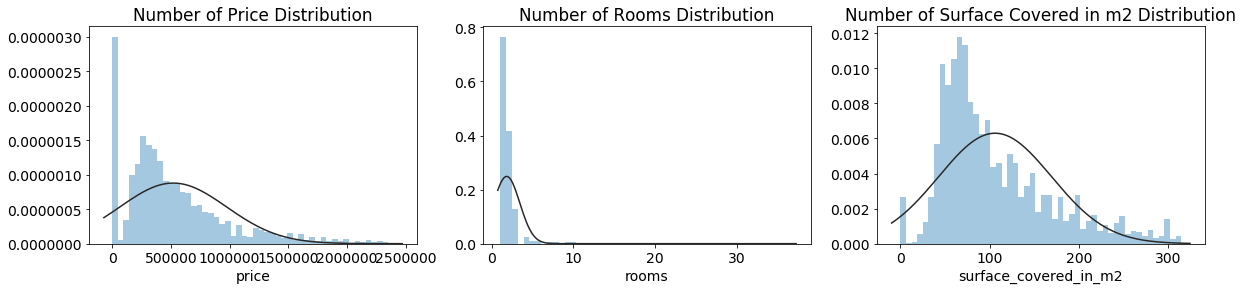

In [28]:
# Distribution of Rooms (after removing the right extreme outliers)

fig, ax = plt.subplots(1,3, figsize=(20,4))

y1 = numeric_features.price[~numeric_features.price.isna()]
y2 = numeric_features.rooms[~numeric_features.rooms.isna()]
y3 = numeric_features.surface_covered_in_m2[~numeric_features.surface_covered_in_m2.isna()]

sns.distplot(y1, ax=ax[0], kde=False, fit=st.norm)
ax[0].set_title('Number of Price Distribution')

sns.distplot(y2, ax=ax[1], kde=False, fit=st.norm)
ax[1].set_title('Number of Rooms Distribution')

sns.distplot(y3, ax=ax[2], kde=False, fit=st.norm)
ax[2].set_title('Number of Surface Covered in m2 Distribution')


In [29]:
numeric_features.describe(percentiles=[0.05,0.5,0.99])

,operation,property_type,place_name,state_name,price,price_aprox_local_currency,price_aprox_usd,surface_covered_in_m2,price_usd_per_m2,price_per_m2,rooms,transaction_month
count,2.705107e+06,2.705107e+06,2.705107e+06,2.705107e+06,2.705107e+06,2.705107e+06,2.705107e+06,2.705107e+06,2.569081e+06,2.565886e+06,1.635783e+06,2.705107e+06
mean,8.915928e-01,7.947859e-01,8.768333e+02,9.076745e+00,5.201946e+05,5.222961e+05,1.594992e+05,1.061696e+02,1.717073e+03,5.607606e+03,1.817903e+00,6.662578e+00
std,3.108940e-01,5.314544e-01,8.038898e+02,5.490155e+00,4.541278e+05,4.563491e+05,1.393603e+05,6.332360e+01,5.979306e+03,1.950318e+04,1.602754e+00,3.404203e+00
min,0.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.666667e+00,1.000000e+00,1.000000e+00
5%,0.000000e+00,0.000000e+00,8.900000e+01,6.000000e+00,8.500000e+02,8.441200e+02,2.577800e+02,3.800000e+01,7.145857e+00,2.375000e+01,1.000000e+00,1.000000e+00
50%,1.000000e+00,1.000000e+00,5.520000e+02,6.000000e+00,4.000000e+05,4.054009e+05,1.238017e+05,8.600000e+01,1.442076e+03,4.705882e+03,1.000000e+00,7.000000e+00
99%,1.000000e+00,2.000000e+00,3.633000e+03,2.200000e+01,2.100000e+06,2.092116e+06,6.388922e+05,3.000000e+02,4.690650e+03,1.527778e+04,1.000000e+01,1.200000e+01
max,1.000000e+00,3.000000e+00,5.186000e+03,2.600000e+01,2.399900e+06,2.603307e+06,7.950000e+05,3.150000e+02,7.088999e+05,2.300000e+06,3.700000e+01,1.200000e+01


Closely looking at the 99% and max values for rooms in the pandas summary, we can see that indeed only a small number of datapoints remains to be the extreme outliers. Hence for the 'rooms' column, I'll be adjusting the quantile to 99% instead of 95%

In [30]:
# Remove outliers outside the 99th percentile for ROOMS
upper_quant = numeric_features.rooms.quantile([.99])
numeric_features = numeric_features.loc[(numeric_features.rooms < upper_quant.values[0])]

Text(0.5, 1.0, 'Number of Surface Covered in m2 Distribution')

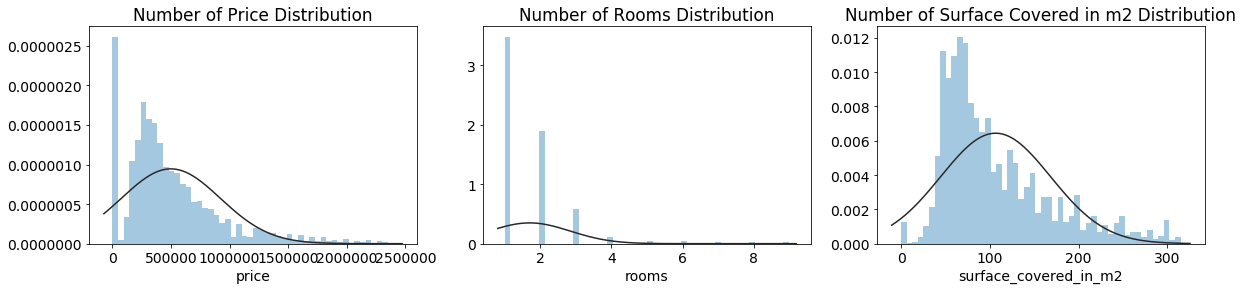

In [31]:
# Distribution of Rooms (after removing the right extreme outliers)

fig, ax = plt.subplots(1,3, figsize=(20,4))

y1 = numeric_features.price[~numeric_features.price.isna()]
y2 = numeric_features.rooms[~numeric_features.rooms.isna()]
y3 = numeric_features.surface_covered_in_m2[~numeric_features.surface_covered_in_m2.isna()]

sns.distplot(y1, ax=ax[0], kde=False, fit=st.norm)
ax[0].set_title('Number of Price Distribution')

sns.distplot(y2, ax=ax[1], kde=False, fit=st.norm)
ax[1].set_title('Number of Rooms Distribution')

sns.distplot(y3, ax=ax[2], kde=False, fit=st.norm)
ax[2].set_title('Number of Surface Covered in m2 Distribution')


Outliers Removed!!

### Exploratory Data Analysis

#### EDA on Target Year

##### Checking assumptions: created_on vs date in filename

In [193]:
## Property Listing Dates for units sold in 201X
DATA_2018_created_on = genData(2018, column = 'created_on')
DATA_2017_created_on = genData(2017, column = 'created_on')
DATA_2016_created_on = genData(2016, column = 'created_on')
DATA_2015_created_on = genData(2015, column = 'created_on')


Load Complete!



Load Complete!



Load Complete!



Load Complete!


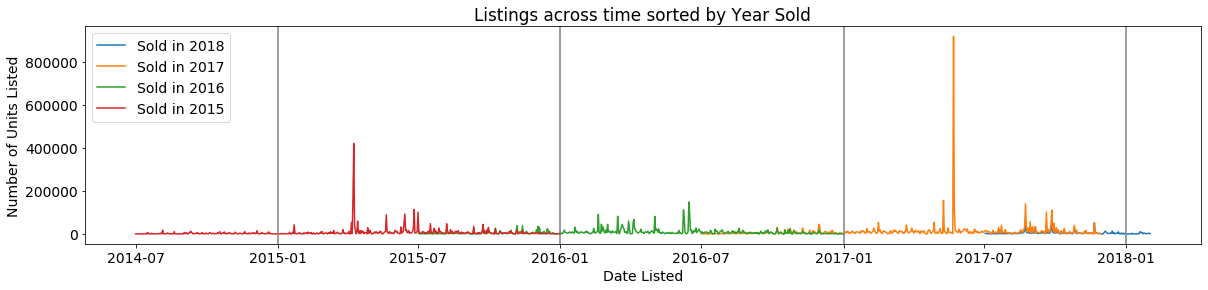

In [197]:
fig, ax = plt.subplots(1,1, figsize=(20,4))

DATA_created_on = pd.concat({'Sold in 2018': DATA_2018_created_on.iloc[:,0].value_counts().sort_index(),
                             'Sold in 2017': DATA_2017_created_on.iloc[:,0].value_counts().sort_index(),
                             'Sold in 2016': DATA_2016_created_on.iloc[:,0].value_counts().sort_index(),
                             'Sold in 2015': DATA_2015_created_on.iloc[:,0].value_counts().sort_index()}, sort=True, axis=1).reset_index()

indices = DATA_created_on['index']
indices = [ datetime.strptime(i, '%Y-%m-%d') for i in indices]

ax.plot(indices, DATA_created_on.iloc[:,1])
ax.plot(indices, DATA_created_on.iloc[:,2])
ax.plot(indices, DATA_created_on.iloc[:,3])
ax.plot(indices, DATA_created_on.iloc[:,4])

ax.legend(DATA_created_on.columns[1:])
ax.axvline('2018-01-01', c='gray')
ax.axvline('2017-01-01', c='gray')
ax.axvline('2016-01-01', c='gray')
ax.axvline('2015-01-01', c='gray')

ax.set_title('Listings across time sorted by Year Sold')
ax.set_xlabel('Date Listed')
ax.set_ylabel('Number of Units Listed')

plt.show()

In [198]:
del DATA_2018_created_on, DATA_2017_created_on, DATA_2016_created_on, DATA_2015_created_on

The chart above shows the behavior of the two date-related data at our disposal; namely, 'created_on' and the date on our filename which we assumed to be 'transaction_year' + 'transaction_month'. Given that the distribution of 'created_on' never exceeds the year indicated in the filename, we can therefore confirm our assumption is very likely correct: the date on our filename is the date in which the transaction happened while the dates under 'created_on' represents the date when the REU was listed on the properati platform.

##### Feature Correlation

In [32]:
data_corr = numeric_features.corr()
print(data_corr['price'].sort_values(ascending = False),'\n')

price                         1.000000
price_aprox_local_currency    0.999307
price_aprox_usd               0.999307
surface_covered_in_m2         0.553471
operation                     0.417558
rooms                         0.168728
price_per_m2                  0.135365
price_usd_per_m2              0.135328
place_name                    0.021125
transaction_month             0.006216
state_name                    0.001295
property_type                -0.071158
Name: price, dtype: float64 



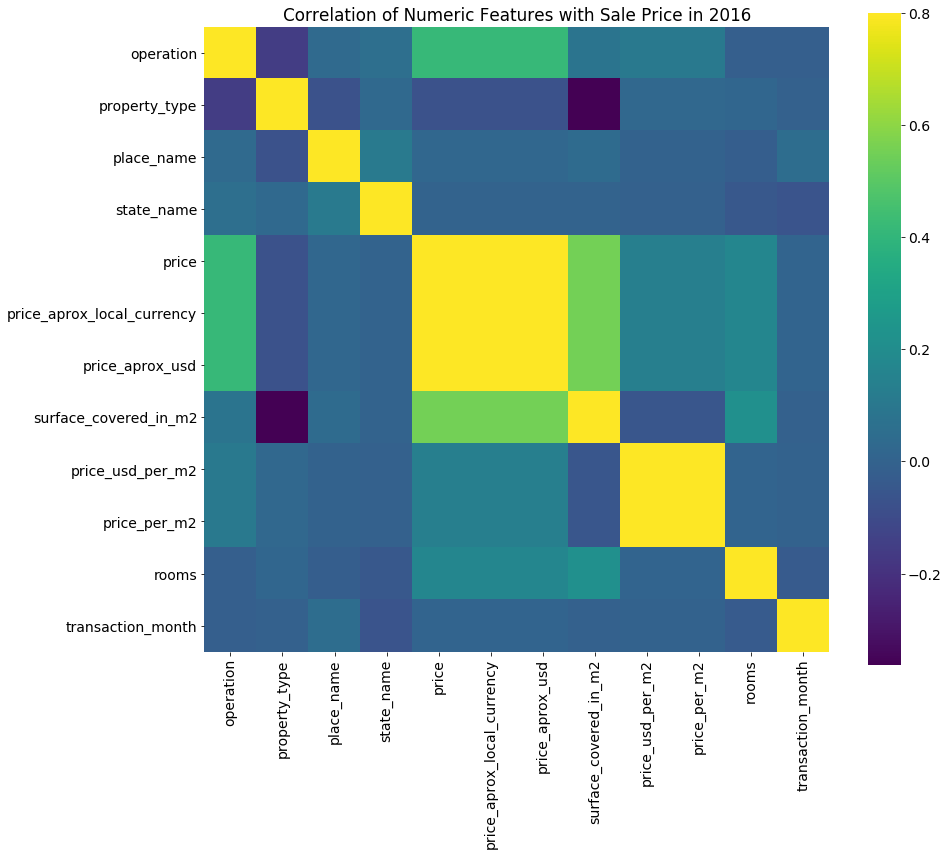

In [33]:
f , ax = plt.subplots(figsize = (14,12))
plt.title('Correlation of Numeric Features with Sale Price in ' + str(set_year),y=1)
sns.heatmap(data_corr,square = True,  vmax=0.8, cmap='viridis')

**OBSERVATIONS** <br>

Right off the bat we see that there is a **moderate corretion** between our targer variable ('price') and both operation (rent or sell) and surface_covered_in_m2, a **weak correlation** between 'price' and 'rooms', and **no correlation** between 'price' and our location variables 'state_name' and 'place_name' as well as our time variables 'transaction_month'

**INTERPRETATIONS** <br>

My thoughts on why this is the case is as follows:
 * It makes sense for operation (rent or sell) to have a decent correlation with price since selling prices of units are typically higher than renting prices and since sell is label-encoded as 1 and rent as 0, the model was able to pick-up a positive correlation. Simply flipping the label-encoding should change the value to negative.
 * Bigger surface covered has a positive correlation with price, denoting that bigger houses in terms of land area are more expensive, which makes sense.
 * The weak correlation between price and rooms also make sense! Since from the same graph, 'rooms' is moderately correlated with 'surface_covered_in_m2', this simply means that bigger houses which tend to be more expensive, tend to have more rooms. But the weak correlation suggests that this isn't always the case. Probably listed here are 1 to 2 room condominium units which can be more expensive that multi-room suburban houses. <br>
 * The practically zero correlation between 'price' and our location variables 'state_name' and 'place_name' initially suggests that location doesn't determine sale price. This is also true for our time variable 'transaction_month'. HOWEVER, it is important to note that these variables hold catergorical data which doesn't fair well with correlation plots as the simple order of the categories could drastically change the correlation values. I will provide a separate analysis for categorical data in the next section to confirm if this is really the case.

##### Property Type vs Sale Price

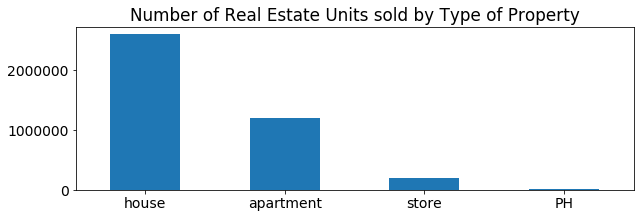

In [34]:
f, ax = plt.subplots(figsize=(10,3))
fig = DATA['property_type'].value_counts().plot.bar()
_=fig.set_xticklabels(CAT_KEYS[CAT_LABELS.index('property_type')], rotation=0)
_=fig.set_title('Number of Real Estate Units sold by Type of Property')

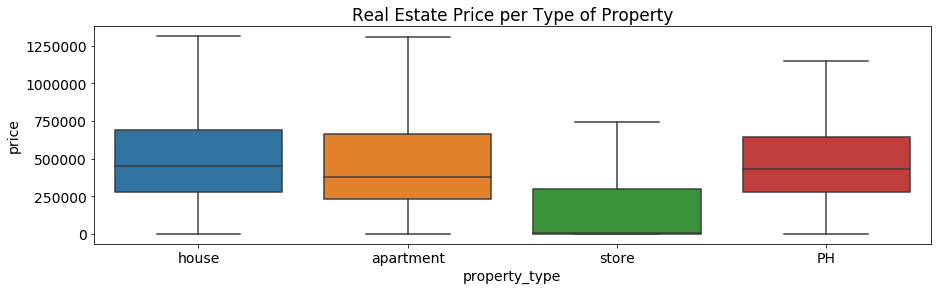

In [41]:
x = 'property_type'
y = 'price'
data = pd.concat([numeric_features[y], numeric_features[x]], axis=1)
f, ax = plt.subplots(figsize=(15, 4))
fig = sns.boxplot(x=x, y=y, data=data, showfliers=False)
_=fig.set_xticklabels(CAT_KEYS[CAT_LABELS.index(x)], rotation=0)
_=fig.set_title('Real Estate Price per Type of Property')

From here we see that diffrent property types are priced relatively the same, with the exception of stores, confirming that indeed there is little to no correlation between prices and property_types.

##### Operation vs Sale Price

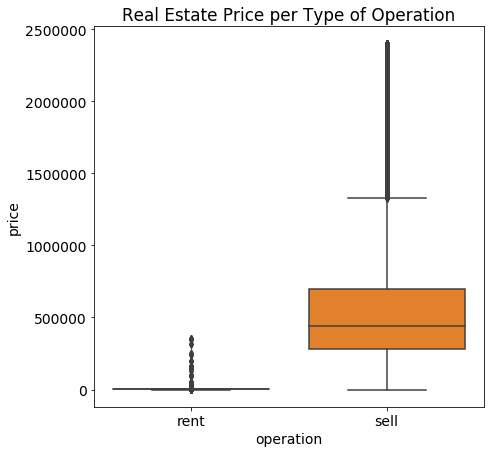

In [43]:
x = 'operation'
y = 'price'
data = pd.concat([numeric_features[y], numeric_features[x]], axis=1)
f, ax = plt.subplots(figsize=(7, 7))
fig = sns.boxplot(x=x, y=y, data=data)
_=fig.set_xticklabels(CAT_KEYS[CAT_LABELS.index(x)], rotation=0)
_=fig.set_title('Real Estate Price per Type of Operation')

As expected, selling REUs are much more expensive that renting them out confirming the moderately high correlation between 'price' and 'operation'. I do have a slight concern and curiosity as to the effects of combining the two datasets. Perhaps the huge discrepancy between selling and renting values is shrouding some important insight that can only be observed when the two are separated. So in the latter part of this notebook I will be analyzing the dataset exclusively for rent operation, and then for sell operation.

##### Location vs Sale Price

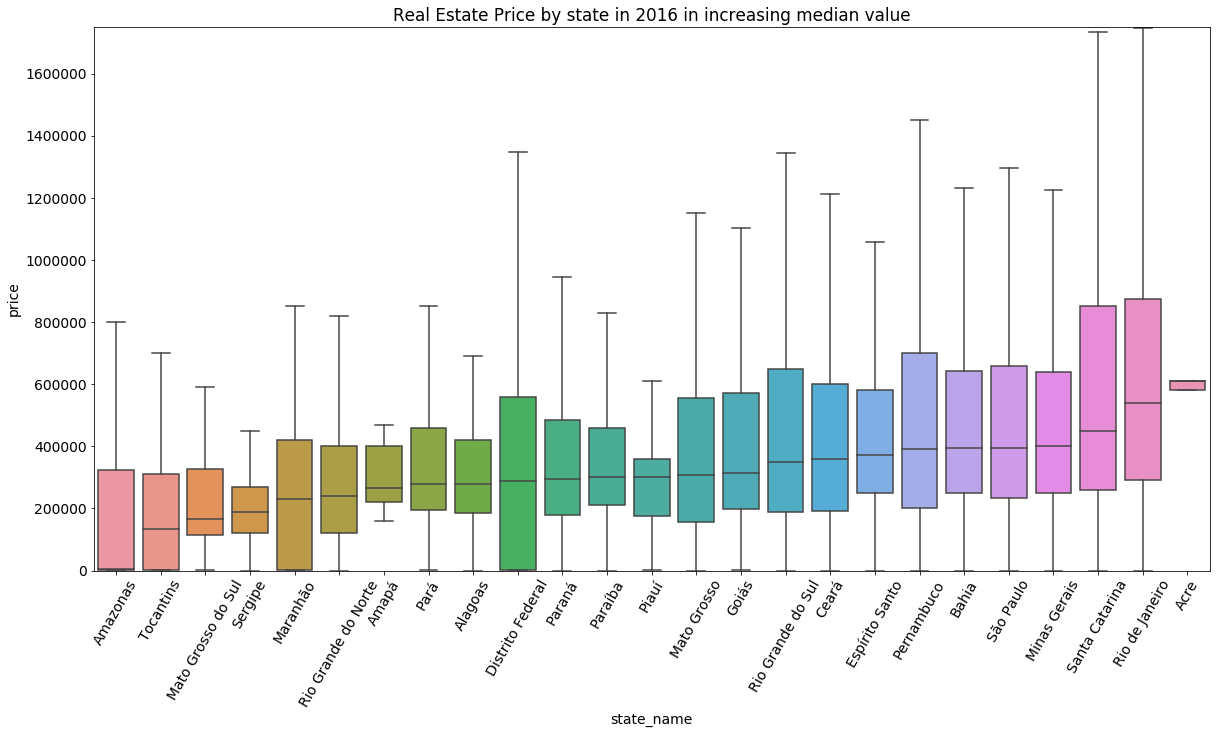

In [37]:
x = 'state_name'
y = 'price'
data = pd.concat([numeric_features[y], numeric_features[x]], axis=1)
order = data.groupby(x)[y].median().sort_values().index
f, ax = plt.subplots(figsize=(20, 10))
fig = sns.boxplot(x=x, y=y, data=data, order=order, showfliers=False)
_=fig.set_xticklabels(CAT_KEYS[CAT_LABELS.index('state_name')][data.groupby(x)[y].median().sort_values().index], rotation=60)
_=fig.set_title('Real Estate Price by state in ' + str(set_year) + ' in increasing median value')
_=fig.set_ylim(0,1750000)

In [38]:
pct_diff = (data.groupby(x)[y].median().sort_values().max() - data.groupby(x)[y].median().sort_values().min()) / data.groupby(x)[y].median().sort_values().min() * 100
print("Percentage Difference between extreme medians: " + str(int(pct_diff)) + "%")

Percentage Difference between extreme medians: 10066%


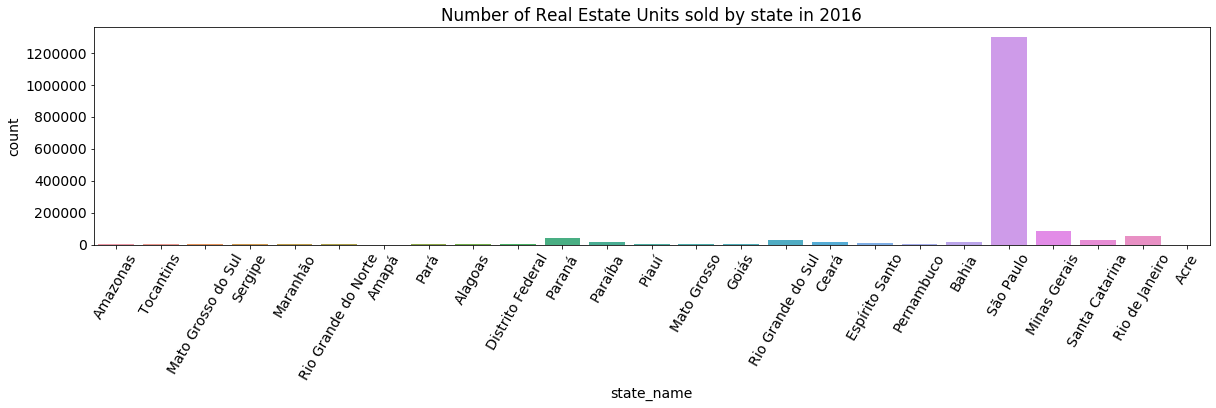

In [39]:
f, ax = plt.subplots(figsize=(20, 4))
fig = sns.countplot(x=x, data=data, order=order)
_=fig.set_xticklabels(CAT_KEYS[CAT_LABELS.index('state_name')][data.groupby(x)[y].median().sort_values().index], rotation=60)
_=fig.set_title('Number of Real Estate Units sold by state in ' + str(set_year))

Analyzing the location features is interesting to me. We saw from the correlation matrix above that 'price' and 'state_name' barely has any correlation (0.001295) which suggests that the state on which the REU is rented/sold does not affect the price of the REU. As mentioned, this value is the output of a flawed correlation approach -- since 'state_names' are categorical in value, the order on which each category appears in the horizontal scale does not distort the data since each category is independent from the rest; but it can drastically shift the fitting line, thereby changing the correlation coefficient. <br>

In the 'Housing Price Distribution by state' plot above, when arranged accordingly, we see that indeed, the location of the REU does have an impact on its price. That is, **REUs are more expensive in some states than in others by up to 240%**.

##### Transaction_month VS Sale Price

transaction_month
1     509103.855362
2     498880.847699
3     496357.547103
4     485106.855716
5     489929.568029
6     489783.132007
7     493319.945592
8     498348.337405
9     499152.554986
10    499093.174848
11    508540.185454
12    510054.352924
Name: price, dtype: float64

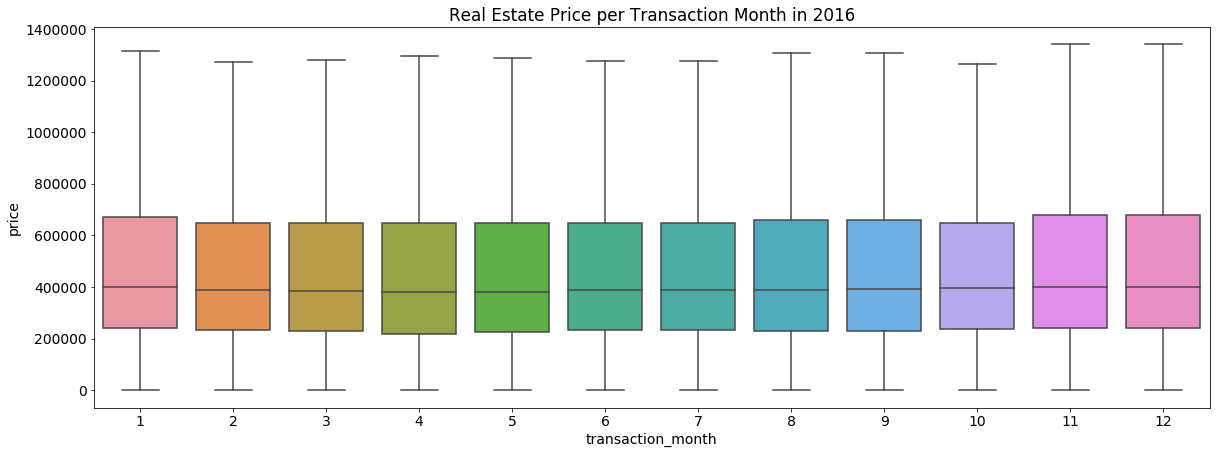

In [40]:
x = 'transaction_month'
y = 'price'
data = pd.concat([numeric_features[y], numeric_features[x]], axis=1)
f, ax = plt.subplots(figsize=(20, 7))
fig = sns.boxplot(x=x, y=y, data=data, showfliers=False)
_=fig.set_title('Real Estate Price per Transaction Month in ' + str(set_year))
data.groupby('transaction_month')['price'].mean()

From the 'Price per Transaction Month' chart we see that prices of REUs are generally the same across different months suggesting that **seasonality does not affect  the sale/rent price of a unit**, and thereby confirming the the output of the correlation matrix (0.006216).

#### EDA on Target Feature across all years

In [97]:
## Update the data generator function to automatically drop NaNs and outliers
## Automate the Transfer of data from GCS to Python (Pandas Dataframe)

def genData2(year, column = None, file_count = None, null_threshold = 50):

    DATA = []
    
    for _, _, bucket_data in fs.walk('tm-application/'):

        for filename in tq.tqdm(bucket_data[:file_count]):

            if int(filename[-6:-2]) == year:

                with fs.open('tm-application/' + filename) as f:
                    data = pd.read_csv(f)
                    
                    # Add list_date column
                    data['transaction_year'] = filename[-6:-2]
                    data['transaction_month'] = filename[-2:]
                    
                    if column:
                        try:
                            data = data.loc[:, column]
                        except:
                            print('Invalid Column!')                    # Drop unwanted columns
                    
                    else:
                        data.drop(['id','place_with_parent_names', 'properati_url', 'description', 'title', 'image_thumbnail'], axis=1, inplace=True)

                    DATA.append(data.values)
    
    if column:
        DATA = pd.DataFrame(np.concatenate(DATA), columns=[column]) #input from user
    else:
        DATA = pd.DataFrame(np.concatenate(DATA), columns=columns) #default full columns
    
    data_cols = DATA.columns #gets the updated column based on column input
    
    ## Drop missing numbers
    DATA = DATA[data_cols[(DATA.isna().mean() * 100) <= null_threshold]]
    
    #print("Drop NaNs success!")
    
    ## Convert to numeric features
    for i in range(DATA.shape[1]):
        try:
            DATA.iloc[:,i] = pd.to_numeric(DATA.iloc[:,i])
        except:
            pass
    
    #print("Convert to Numeric Features success!")
    
    ## Remove outliers
    try:
        # Remove outliers outside the 95th percentile for PRICE
        upper_quant = DATA.price.quantile([.95])
        DATA = DATA.loc[(DATA.price < upper_quant.values[0])]
    except:
        pass
    try:
        # Remove outliers outside the 5th to 95th percentile for surface_covered_in_m2
        upper_quant = DATA.surface_covered_in_m2.quantile([.95])
        DATA = DATA.loc[(DATA.surface_covered_in_m2 < upper_quant.values[0])]
    except:
        pass
    try:
        # Remove outliers outside the 99th percentile for ROOMS
        upper_quant = DATA.rooms.quantile([.99])
        DATA = DATA.loc[(DATA.rooms < upper_quant.values[0])]
    except:
        pass
    
    #print("Remove Outliers success!")
    
    #print("Load Complete!")

    return DATA

##### Transaction_year vs Sale Price

In [ ]:
del DATA, data

In [98]:
## Property Listing Dates for units sold in 201X
DATA_2018_year = genData2(2018, column = ['price','transaction_year'])
DATA_2017_year = genData2(2017, column = ['price','transaction_year'])
DATA_2016_year = genData2(2016, column = ['price','transaction_year'])
DATA_2015_year = genData2(2015, column = ['price','transaction_year'])

In [99]:
DATA_YEAR = pd.concat([DATA_2018_year, DATA_2017_year], axis=0)
DATA_YEAR = pd.concat([DATA_YEAR, DATA_2016_year], axis=0)
DATA_YEAR = pd.concat([DATA_YEAR, DATA_2015_year], axis=0)

# Fix the column header bug
updated_cols = []
for i in range(len(DATA_YEAR.dropna().columns)):
    updated_cols.append(DATA_YEAR.dropna().columns[i][0])

DATA_YEAR.columns = updated_cols

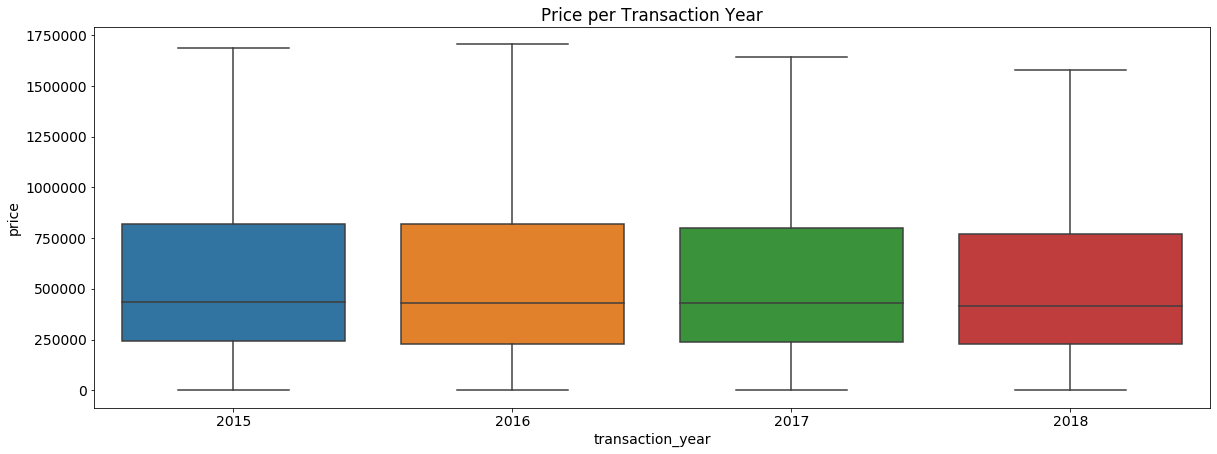

In [141]:
x = 'transaction_year'
y = 'price'
f, ax = plt.subplots(figsize=(20, 7))
fig = sns.boxplot(x=x, y=y, data=DATA_YEAR.dropna(), showfliers = False)
_=fig.set_title('Price per Transaction Year')

In [142]:
del DATA_YEAR, DATA_2018_year, DATA_2017_year, DATA_2016_year, DATA_2015_year

The 'Price per Transaction Year' boxplot shows us that the overall distribution of prices (excluding the outliers) are the almost the same across the years (2016 to 2018) suggesting that **the selling price of a Real Estate Unit is not affected by the year the unit was sold**, at least in the short term (4 years). <br>

Personally I find this observation rather surprising as I expected to observe some shifts between the years especially considering that 2016 is the year when Brazil held the Summer Olympic Games in Rio de Janiero, or that the years 2017 and 2018 saw a big leap in Brazil's GDP. 

![](https://benjaminstudebaker.files.wordpress.com/2016/12/brazil-gdp-growth-2011-2016.png)

Expanding this view across decades might reveal a trend; but for the sake of this research, we'll confine analysis within the specified years and conclude with the aforementioned insight.

##### Total Transactions per State per Year

In [144]:
## Property Listing Dates for units sold in 201X
DATA_2018_year = genData2(2018, column = ['state_name','transaction_year'])
DATA_2017_year = genData2(2017, column = ['state_name','transaction_year'])
DATA_2016_year = genData2(2016, column = ['state_name','transaction_year'])
DATA_2015_year = genData2(2015, column = ['state_name','transaction_year'])

D:\Users\Rein\Anaconda3\envs\PythonGPU\lib\site-packages\IPython\core\interactiveshell.py:3242: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [147]:
DATA_STATES = pd.concat([DATA_2018_year, DATA_2017_year], axis=0)

In [148]:
DATA_STATES = pd.concat([DATA_STATES, DATA_2016_year], axis=0)

In [149]:
DATA_STATES = pd.concat([DATA_STATES, DATA_2015_year], axis=0)

In [150]:
# Fix the column header bug
updated_cols = []
for i in range(len(DATA_STATES.dropna().columns)):
    updated_cols.append(DATA_STATES.dropna().columns[i][0])

DATA_STATES.columns = updated_cols

In [161]:
_, xtick_keys = pd.factorize(DATA_STATES.state_name)

Text(0.5, 1.0, 'Real Estate Units sold per State in 2016-2018')

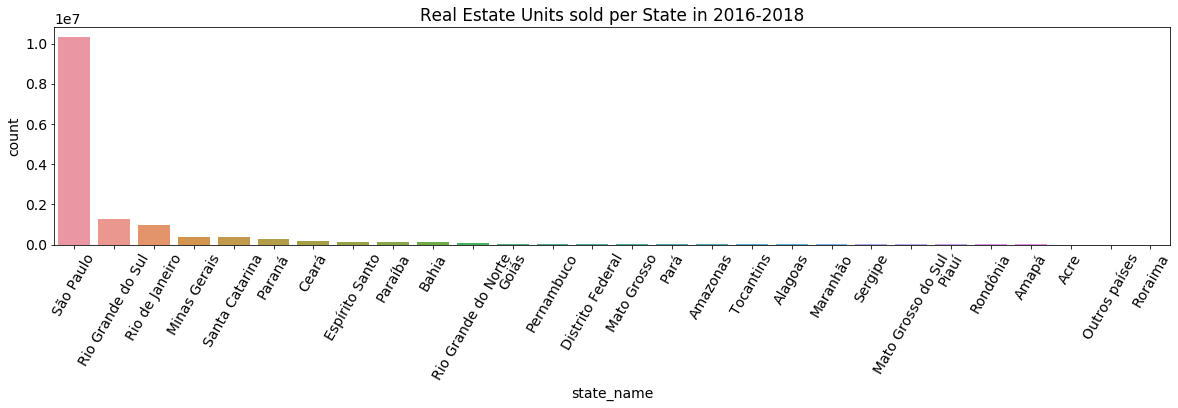

In [191]:
x = 'state_name'
y = 'transaction_year'
order = DATA_STATES.groupby(x)[y].sum().sort_values(ascending=False).index
f, ax = plt.subplots(figsize=(20, 4))
fig = sns.countplot(x=x, data=DATA_STATES.dropna(), order=order)
ax.tick_params(axis='x', rotation=60)
ax.set_title('Real Estate Units sold per State in 2016-2018')

In [192]:
del DATA_STATES, DATA_2018_year, DATA_2017_year, DATA_2016_year, DATA_2015_year

Here lies an interesting, but somewhat concerning issue with the dataset from Properati. A huge majority of the information from the datasets available comes from listings in the Sao Paulo state. Therefore we potentially run the risk of creating a conclusion that is heavily biased on Sao Paolo. <br>

**So should I try to balance out the distribution of data across different states?**

It is possible; however since there are multiple states (by multiple, I mean almost half of them) that practically have zero data available, relative to what's available for Sao Paolo, forcing to balance out the data distribution would run the risk of heavily distorting the data. In my opinion, if we want to balance out the dataset in order to properly and equally account for the Real Estate transactions across all the cities, the first thing we have to do is to gather more property listing data in other states. <br>

Hence, for this project, I'll keep the data distribution as it is.

**Why are there so many listings in Sao Paolo anyway?**

First, Sao Paolo is the [most populated state](https://en.wikipedia.org/wiki/List_of_Brazilian_states_by_population) in Brazil at 46M people, which is more than double the second most populous area, Minas Gerais. It is also the second highest state in terms of [GDP per capita](https://www.worldatlas.com/articles/the-richest-and-poorest-states-of-brazil.html), after Distrito Federal and before Rio de Janiero. Which, I think, makes the perfect starting market for a property listing startup like Properati.

#### EDA with Contant Variable ('operation') on Target Year

##### Operation set to Rent

In [265]:
# Extract all rent data
DATA_RENT = numeric_features[numeric_features.operation == 0]

**Correlation Matrix**

In [266]:
data_corr = DATA_RENT.corr()
print(data_corr['price'].sort_values(ascending = False),'\n')

price                         1.000000
price_aprox_usd               0.999561
price_aprox_local_currency    0.999561
surface_covered_in_m2         0.390003
price_per_m2                  0.174289
price_usd_per_m2              0.173909
rooms                         0.158946
place_name                    0.021681
transaction_month             0.007940
property_type                -0.000641
state_name                   -0.045500
operation                          NaN
Name: price, dtype: float64 



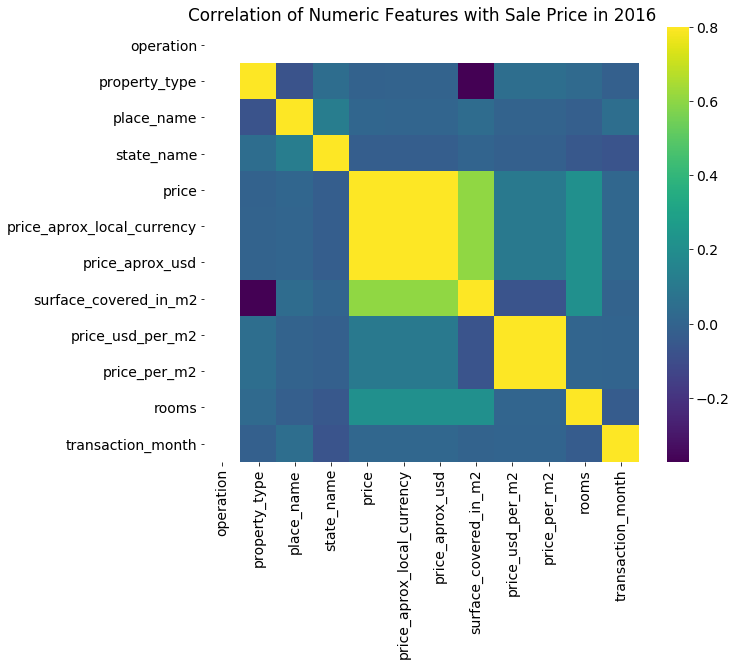

In [303]:
f , ax = plt.subplots(figsize = (10,8))
plt.title('Correlation of Numeric Features with Sale Price in 2016',y=1)
sns.heatmap(data_corr,square = True,  vmax=0.8, cmap='viridis')

**By Property Type**

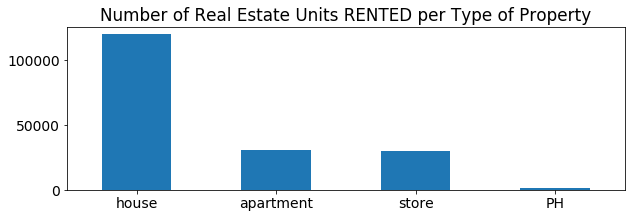

In [301]:
f, ax = plt.subplots(figsize=(10,3))
fig = DATA_RENT['property_type'].value_counts().plot.bar()
_=fig.set_xticklabels(CAT_KEYS[CAT_LABELS.index('property_type')], rotation=0)
_=fig.set_title('Number of Real Estate Units RENTED per Type of Property')

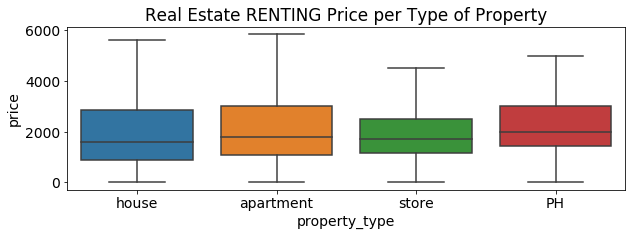

In [300]:
x = 'property_type'
y = 'price'
data = pd.concat([DATA_RENT[y], DATA_RENT[x]], axis=1)
f, ax = plt.subplots(figsize=(10, 3))
fig = sns.boxplot(x=x, y=y, data=data, showfliers=False)
_=fig.set_xticklabels(CAT_KEYS[CAT_LABELS.index(x)], rotation=0)
_=fig.set_title('Real Estate RENTING Price per Type of Property')

**By State**

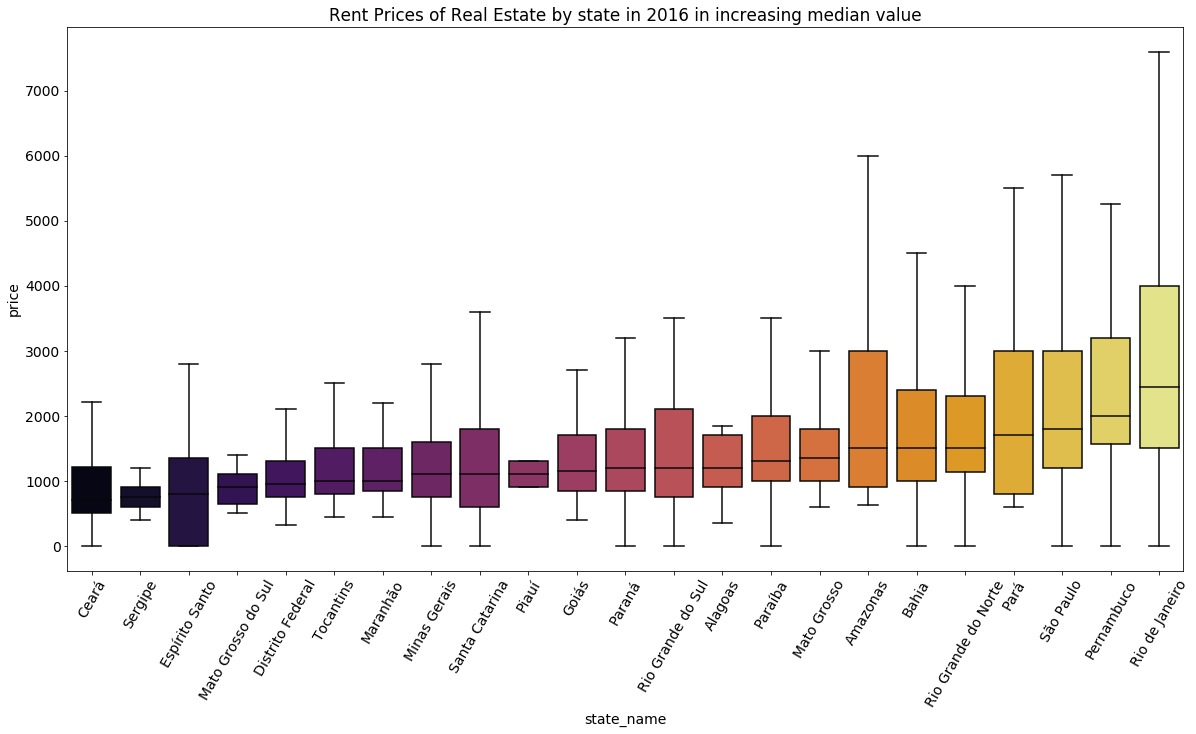

In [319]:
x = 'state_name'
y = 'price'
data = pd.concat([DATA_RENT[y], DATA_RENT[x]], axis=1)
order = data.groupby(x)[y].median().sort_values().index
f, ax = plt.subplots(figsize=(20, 10))
fig = sns.boxplot(x=x, y=y, data=data, order=order, showfliers=False, palette='inferno')
_=fig.set_xticklabels(CAT_KEYS[CAT_LABELS.index('state_name')][data.groupby(x)[y].median().sort_values().index], rotation=60)
_=fig.set_title('Rent Prices of Real Estate by state in ' + str(set_year) + ' in increasing median value')

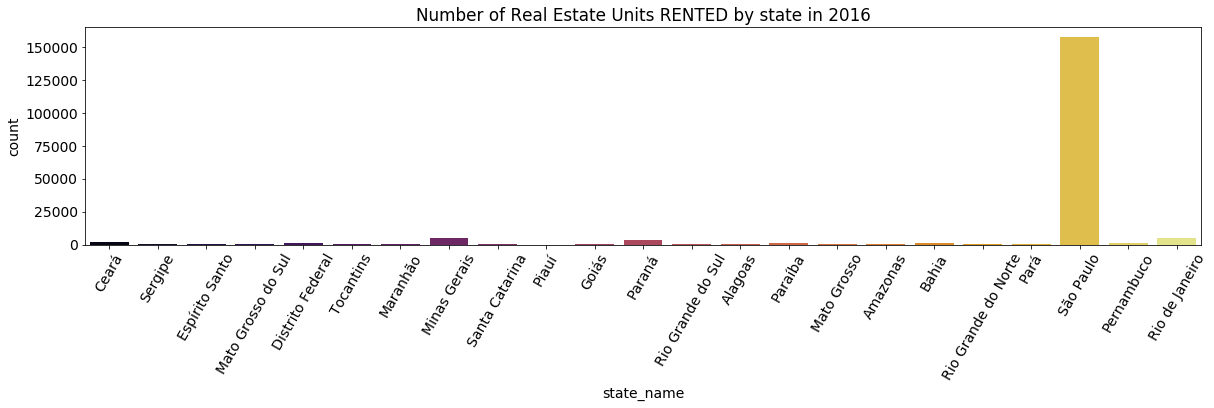

In [320]:
f, ax = plt.subplots(figsize=(20, 4))
fig = sns.countplot(x=x, data=data, order=order, palette='inferno')
_=fig.set_xticklabels(CAT_KEYS[CAT_LABELS.index('state_name')][data.groupby(x)[y].median().sort_values().index], rotation=60)
_=fig.set_title('Number of Real Estate Units RENTED by state in ' + str(set_year))

**By Month**

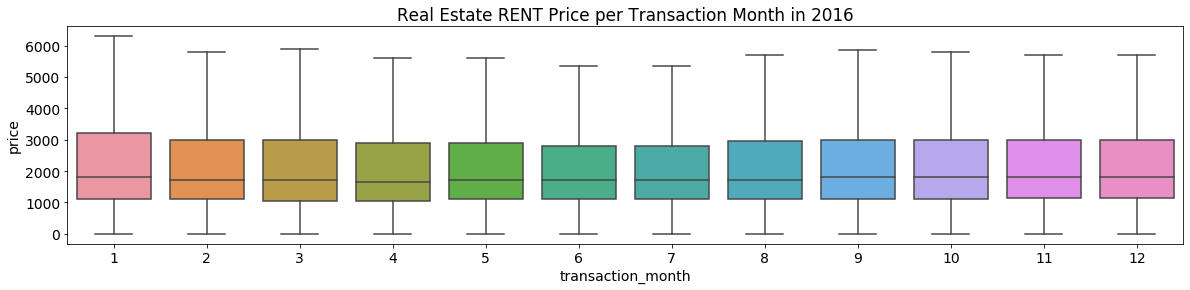

In [316]:
x = 'transaction_month'
y = 'price'
data = pd.concat([DATA_RENT[y], DATA_RENT[x]], axis=1)
f, ax = plt.subplots(figsize=(20, 4))
fig = sns.boxplot(x=x, y=y, data=data, showfliers=False)
_=fig.set_title('Real Estate RENT Price per Transaction Month in ' + str(set_year))

##### Operation set to Sell

In [289]:
# Extract all rent data
DATA_SELL = numeric_features[numeric_features.operation == 1]

**Correlation Matrix**

In [290]:
data_corr = DATA_SELL.corr()
print(data_corr['price'].sort_values(ascending = False),'\n')

price                         1.000000
price_aprox_local_currency    0.999161
price_aprox_usd               0.999161
surface_covered_in_m2         0.607337
rooms                         0.210087
price_usd_per_m2              0.099834
price_per_m2                  0.099811
transaction_month             0.015128
place_name                    0.008378
property_type                -0.005893
state_name                   -0.025580
operation                          NaN
Name: price, dtype: float64 



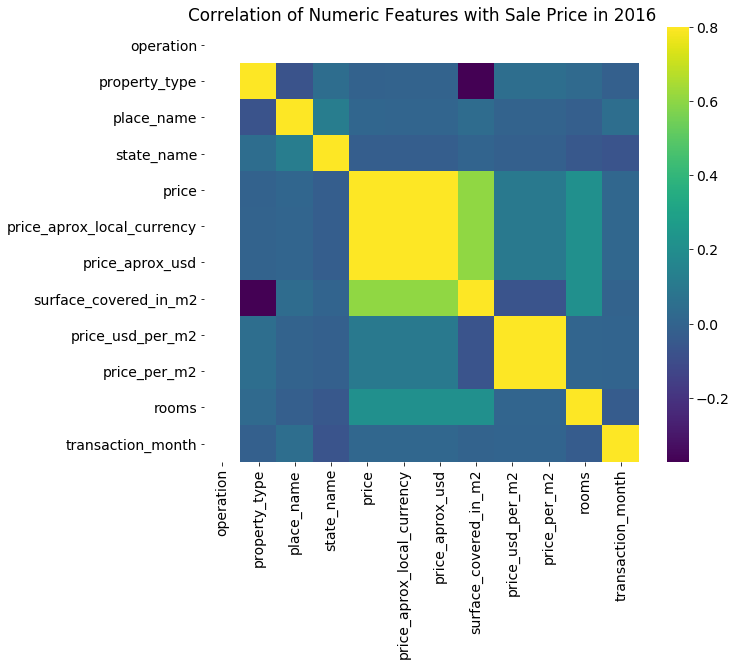

In [302]:
f , ax = plt.subplots(figsize = (10,8))
plt.title('Correlation of Numeric Features with Sale Price in 2016',y=1)
sns.heatmap(data_corr,square = True,  vmax=0.8, cmap='viridis')

**By Property Type**

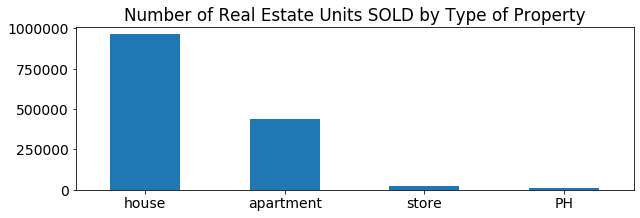

In [299]:
f, ax = plt.subplots(figsize=(10,3))
fig = DATA_SELL['property_type'].value_counts().plot.bar()
_=fig.set_xticklabels(CAT_KEYS[CAT_LABELS.index('property_type')], rotation=0)
_=fig.set_title('Number of Real Estate Units SOLD by Type of Property')

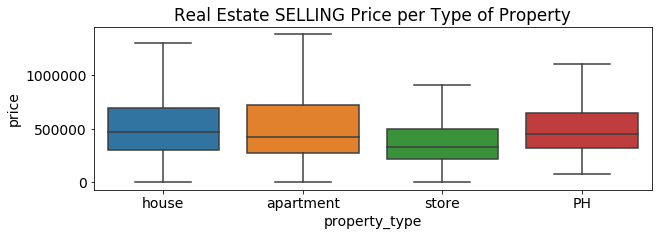

In [298]:
x = 'property_type'
y = 'price'
data = pd.concat([DATA_SELL[y], DATA_SELL[x]], axis=1)
f, ax = plt.subplots(figsize=(10, 3))
fig = sns.boxplot(x=x, y=y, data=data, showfliers=False)
_=fig.set_xticklabels(CAT_KEYS[CAT_LABELS.index(x)], rotation=0)
_=fig.set_title('Real Estate SELLING Price per Type of Property')

**By State**

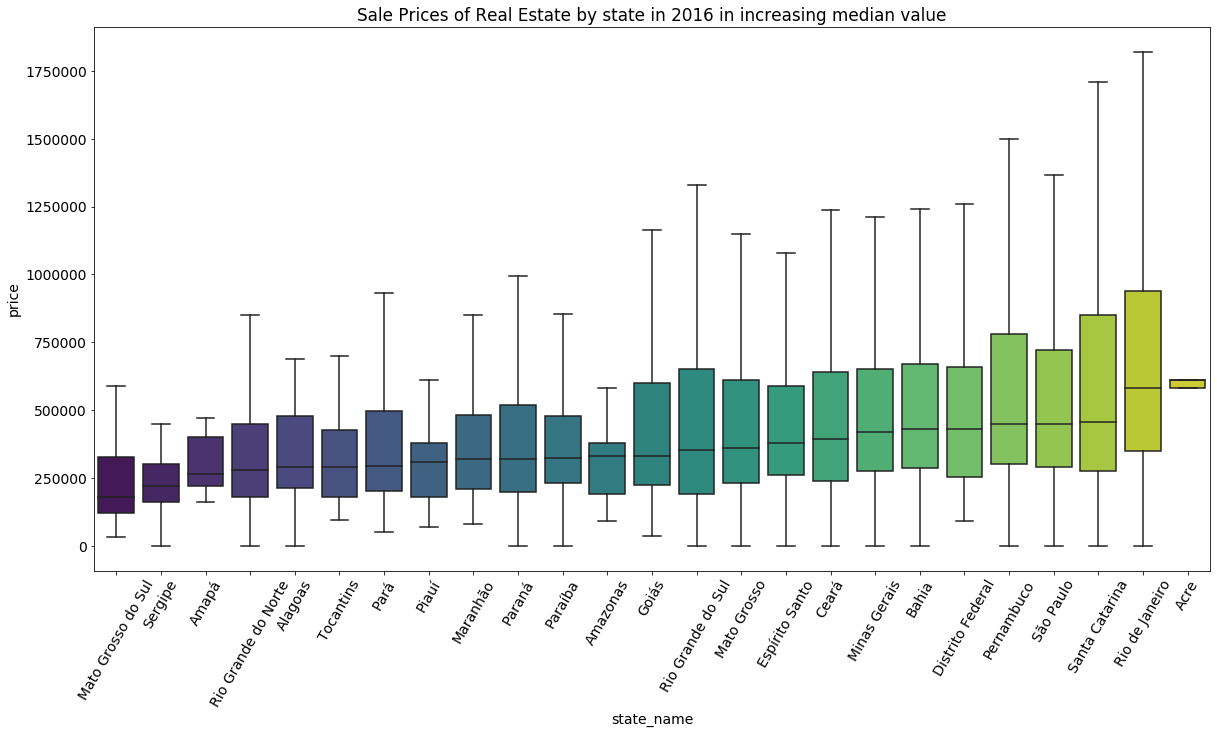

In [321]:
x = 'state_name'
y = 'price'
data = pd.concat([DATA_SELL[y], DATA_SELL[x]], axis=1)
order = data.groupby(x)[y].median().sort_values().index
f, ax = plt.subplots(figsize=(20, 10))
fig = sns.boxplot(x=x, y=y, data=data, order=order, showfliers=False, palette='viridis')
_=fig.set_xticklabels(CAT_KEYS[CAT_LABELS.index('state_name')][data.groupby(x)[y].median().sort_values().index], rotation=60)
_=fig.set_title('Sale Prices of Real Estate by state in ' + str(set_year) + ' in increasing median value')

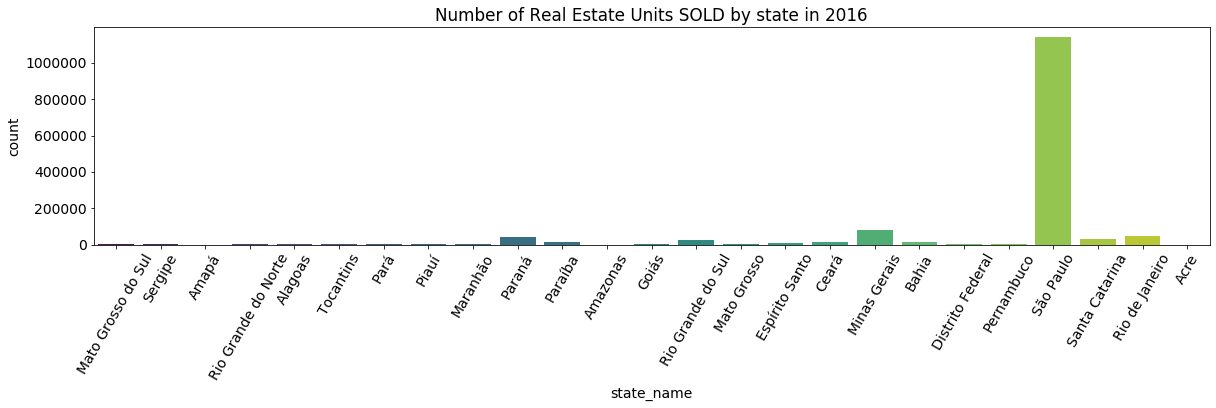

In [322]:
f, ax = plt.subplots(figsize=(20, 4))
fig = sns.countplot(x=x, data=data, order=order, palette='viridis')
_=fig.set_xticklabels(CAT_KEYS[CAT_LABELS.index('state_name')][data.groupby(x)[y].median().sort_values().index], rotation=60)
_=fig.set_title('Number of Real Estate Units SOLD by state in ' + str(set_year))

**By Month**

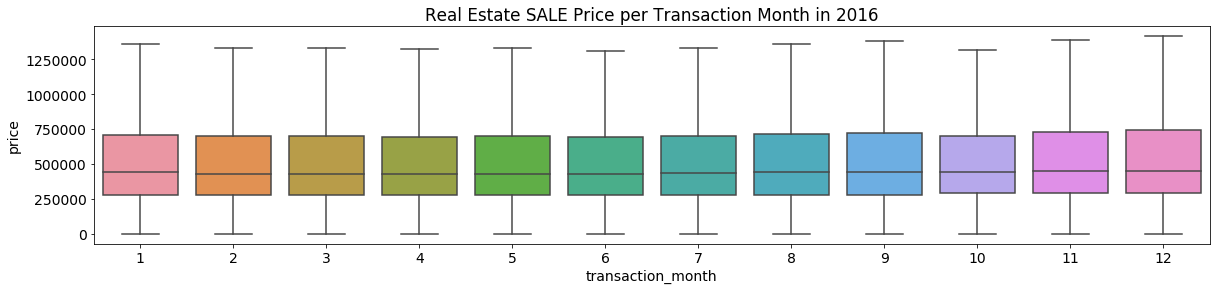

In [314]:
x = 'transaction_month'
y = 'price'
data = pd.concat([DATA_SELL[y], DATA_SELL[x]], axis=1)
f, ax = plt.subplots(figsize=(20, 4))
fig = sns.boxplot(x=x, y=y, data=data, showfliers=False)
_=fig.set_title('Real Estate SALE Price per Transaction Month in ' + str(set_year))

##### Analysis on EDA with Constant Variable ('operation')

Setting Rent prices to a constant value and then analyzing the behaviour of other variables, as proposed in the observation in section 1.6.1.4 of this notebook ('Operation vs Sale Price'), we see **no significant different** in the behaviour of other variables in relation to price between operation = rent and operation = sell. <br>

The only curious observation I had was in the Prices by State tables for both Rent and Sell. These graphs show that there are states where RENTAL units are more expensive than others, and there are states where units for SALE are more expensive than others. But it does not necessarily mean that the cities with expensive rental prices are also the cities with expensive sale prices. Take for instance the state of "Para," which is one of the top 5 most expensive rentals, while being one of the states offering the cheapest selling prices.

### Conclusion

In this short EDA exercise we saw that, indeed, **sale prices are determined by both internal (characteristics of the unit) and external factors (characteristics of the environment the unit sold/rented)**, thereby confirming our initial theory.

By analyzing the Dataset from Properati, I'm able to generate the following insights:

 1. Bigger Real Estate Units are generally more expensive that smaller ones. We saw that the surface_covered_in_m2 variable is moderately correlated with price at a correlation coefficient of 0.553471; which confirms our hypothesis. Moderate correlation is also expected since the contents / furnishings / and other factors also play a role in a unit's pricing (i.e., a smaller but highly-furnished condo in the city center of Sao Paolo is expected to be more expensive than a bigger rustic home in the Maranhao).
 
 2. The location of the Real Estate Unit plays a part in determining price. From the 'Real Estate Price by State' boxplots, when arranged in increasing Median values, we can clearly see that some states offer more expensive REUs than others (by up to 240%) which confirms my hypothesis.
 
 3. Time, whether by month or by year, does NOT affect the pricing of REUs for rent, sell, and both rent and sell operations. From section 1.6.1.2, the correlation of our 'transaction_month' variable against price and got a correlation coefficient of 0.006216 (or practically zero). The boxplots in sections 1.6.1.6 (Transaction_month VS Sale Price), 1.6.3.1 (Operation set to Rent), and 1.6.3.2 (Operation set to Sell) also showed no signs of any significant shifts across different months. Furthermore, the boxplot in section 1.6.2.1 (Transaction_year vs Sale Price) also shows that the prices of REUs for each year from 2015 to 2018 also shows no significant shifts. Therefore, this rejects my hypothesis that time and seasonality affects REU prices.
 
**Who cares??**
 
For someone looking to buy or rent a house in Brazil on a budget, the cheapest ones are the smaller units located in the rural districts of Sergipipe and Maranhao. For someone who feels the pressure of buying a house soon in fears that the prices might increase past their budget over the following years, we can confirm that the prices of Brazilian Real Estate Units does not vary over time -- or atleast within 4 year windows.

**Some Disclaimers**

The insights presented here is limited only to the data available from the Properati platform. It is important to note that this might note accurately depict the true Real Estate environment of the entire Brazil because the Properati data is skewed towards Sao Paulo units. Approximately 90% of the data comes from Sao Paulo -- a developed Brazilian state. Hence, we might not be painting a fully accurate picture of the effects of different factors across other Brazilian states. As mentioned in section 1.6.2.2 (Total Transactions per State per Year), I chose not to perform any data distribution normalization or balancing because the steep difference in the entries listed under Sao Paulo and the rest of the states would probably heavily distort the information contained within the dataset. <br>

Besides, the fact that Properati is so popular in Sao Paulo also has its own insight: that maybe, Sao Paulo, being the most populous state in Brazil is also the most active in terms of Real Estate; and hence, would perhaps be a good enough central indicator of Brazil's Real Estate development.

~ END ~